## 1. Import Libraries and Setup

In [1]:
import os
import json
import time
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import librosa
from librosa.filters import mel as librosa_mel_fn
from librosa import stft, istft
from librosa.util import pad_center, tiny
from scipy.signal import get_window
from torchaudio import transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Configuration Parameters

In [13]:
import os
os.chdir("D:/Main Storage/Vscode/tb_kaggle")

In [ ]:
class Config:
    def __init__(self):
        # Audio processing parameters
        self.sampling_rate = 16000
        self.desired_length = 1.0
        self.fade_samples_ratio = 6
        self.pad_types = "repeat"
        
        # STFT parameters
        self.filter_length = 1024
        self.hop_length = 256
        self.win_length = 1024
        self.window = 'hann'
        
        # MFCC parameters
        self.n_mfcc = 13           # Number of MFCC coefficients
        self.n_mels = 40           # Number of mel-frequency bands
        self.fmin = 0.0            # Minimum frequency
        self.fmax = 8000.0         # Maximum frequency
        
        # Cough segmentation parameters
        self.cough_padding = 0.5
        self.min_cough_len = 0.2
        self.th_l_multiplier = 0.02
        self.th_h_multiplier = 5
        
        # Model parameters (matching checkpoint dimensions)
        self.input_size = 39       # 13 MFCC + 13 Delta + 13 Delta-Delta
        self.hidden_size = 512     # Hidden size from checkpoint
        self.output_size = 2
        self.dropout = 0.1
        
        # Model paths
        self.model_path = "model/LSTM_mfcc_model.pth"

config = Config()

## 2.1. MFCC Feature Extraction

In [3]:
def extract_mfcc_features(audio, sample_rate, config):
    """
    Extract MFCC features with delta and delta-delta coefficients
    
    Args:
        audio: Audio signal array
        sample_rate: Sampling rate
        config: Configuration object
    
    Returns:
        mfcc_features: Array of shape (39, n_frames) - 13 MFCC + 13 Delta + 13 Delta-Delta
    """
    # Extract MFCC coefficients
    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=sample_rate,
        n_mfcc=config.n_mfcc,
        n_mels=config.n_mels,
        n_fft=config.filter_length,
        hop_length=config.hop_length,
        fmin=config.fmin,
        fmax=config.fmax
    )
    
    # Compute delta features (first derivatives)
    delta_mfcc = librosa.feature.delta(mfcc)
    
    # Compute delta-delta features (second derivatives)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    
    # Concatenate all features: [MFCC, Delta, Delta-Delta]
    mfcc_features = np.vstack([mfcc, delta_mfcc, delta2_mfcc])  # Shape: (39, n_frames)
    
    return mfcc_features

def process_audio_to_mfcc(audio_path, config):
    """
    Load audio file and extract MFCC features
    
    Args:
        audio_path: Path to audio file
        config: Configuration object
    
    Returns:
        mfcc_tensor: PyTorch tensor of shape (sequence_length, 39)
    """
    # Load audio
    audio, sr = librosa.load(audio_path, sr=config.sampling_rate)
    
    # Extract MFCC features
    mfcc_features = extract_mfcc_features(audio, sr, config)
    
    # Transpose to (n_frames, n_features) for LSTM input
    mfcc_features = mfcc_features.T  # Shape: (n_frames, 39)
    
    # Convert to PyTorch tensor
    mfcc_tensor = torch.FloatTensor(mfcc_features)
    
    # Add batch dimension: (1, n_frames, 39)
    mfcc_tensor = mfcc_tensor.unsqueeze(0)
    
    return mfcc_tensor

## 3. STFT Implementation

In [4]:
def window_sumsquare(window, n_frames, hop_length=200, win_length=800, n_fft=800, dtype=np.float32, norm=None):
    if win_length is None:
        win_length = n_fft
    n_fft = int(n_fft)
    hop_length = int(hop_length)
    win_length = int(win_length)
    n_frames = int(n_frames)
    
    x = np.zeros(n_fft + hop_length * (n_frames - 1), dtype=dtype)
    win_sq = get_window(window, win_length, fftbins=True)
    win_sq = librosa.util.normalize(win_sq, norm=norm)**2
    win_sq = pad_center(win_sq, size=n_fft)
    
    for i in range(n_frames):
        sample = i * hop_length
        x[sample:min(n_fft + sample, len(x))] += win_sq[:max(0, min(n_fft, len(x) - sample))]
    return x

class STFT(torch.nn.Module):
    def __init__(self, filter_length=800, hop_length=200, win_length=800, window='hann'):
        super(STFT, self).__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.forward_transform = None
        scale = self.filter_length / self.hop_length
        fourier_basis = np.fft.fft(np.eye(self.filter_length))

        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                   np.imag(fourier_basis[:cutoff, :])])

        forward_basis = torch.FloatTensor(fourier_basis[:, None, :]) 
        inverse_basis = torch.FloatTensor(np.linalg.pinv(scale * fourier_basis).T[:, None, :])

        if window is not None:
            assert(filter_length >= win_length)
            fft_window = get_window(window, win_length, fftbins=True)
            fft_window = pad_center(fft_window, size=filter_length)
            fft_window = torch.from_numpy(fft_window).float()
            forward_basis *= fft_window
            inverse_basis *= fft_window

        self.register_buffer('forward_basis', forward_basis.float())
        self.register_buffer('inverse_basis', inverse_basis.float())

    def transform(self, input_data):
        num_batches = input_data.size(0)
        num_samples = input_data.size(1)
        self.num_samples = num_samples

        if input_data.device.type == "cuda":
            input_data = input_data.view(num_batches, 1, num_samples)
            input_data = F.pad(input_data.unsqueeze(1),
                              (int(self.filter_length / 2), int(self.filter_length / 2), 0, 0),
                              mode='reflect')
            input_data = input_data.squeeze(1)
            
            forward_transform = F.conv1d(input_data, self.forward_basis,
                                       stride=self.hop_length, padding=0)
            cutoff = int((self.filter_length / 2) + 1)
            real_part = forward_transform[:, :cutoff, :]
            imag_part = forward_transform[:, cutoff:, :]
        else:
            x = input_data.detach().numpy()
            real_part = []
            imag_part = []
            for y in x:
                y_ = stft(y=y, n_fft=self.filter_length, hop_length=self.hop_length, 
                         win_length=self.win_length, window=self.window)
                real_part.append(y_.real[None,:,:])
                imag_part.append(y_.imag[None,:,:])
            real_part = np.concatenate(real_part, 0)
            imag_part = np.concatenate(imag_part, 0)
            
            real_part = torch.from_numpy(real_part).to(input_data.dtype)
            imag_part = torch.from_numpy(imag_part).to(input_data.dtype)

        magnitude = torch.sqrt(real_part**2 + imag_part**2)
        phase = torch.atan2(imag_part.data, real_part.data)
        return magnitude, phase

    def forward(self, input_data):
        self.magnitude, self.phase = self.transform(input_data)
        return self.magnitude

## 4. Mel-Spectrogram Transform

In [5]:
def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

class TacotronSTFT(nn.Module):
    def __init__(self, filter_length=1024, hop_length=256, win_length=1024,
                 n_mel_channels=80, sampling_rate=22050, mel_fmin=0.0, mel_fmax=8000.0):
        super(TacotronSTFT, self).__init__()
        self.n_mel_channels = n_mel_channels
        self.sampling_rate = sampling_rate
        self.stft_fn = STFT(filter_length, hop_length, win_length)
        
        mel_basis = librosa_mel_fn(sr=sampling_rate, n_fft=filter_length, 
                                  n_mels=n_mel_channels, fmin=mel_fmin, fmax=mel_fmax)
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer('mel_basis', mel_basis)

    def spectral_normalize(self, magnitudes):
        return dynamic_range_compression(magnitudes)

    def forward(self, y):
        y = y.unsqueeze(0)
        assert(torch.min(y.data) >= -1)
        assert(torch.max(y.data) <= 1)

        magnitudes, phases = self.stft_fn.transform(y)
        magnitudes = magnitudes.data
        mel_output = torch.matmul(self.mel_basis, magnitudes)
        mel_output = self.spectral_normalize(mel_output).squeeze(0)
        return mel_output

## 5. Audio Preprocessing Functions

In [6]:
def cut_pad_sample(data, sample_rate, desired_length, pad_types='zero'):
    fade_samples_ratio = 6
    fade_samples = int(sample_rate / fade_samples_ratio)
    fade_out = T.Fade(fade_in_len=0, fade_out_len=fade_samples, fade_shape='linear')
    target_duration = int(desired_length * sample_rate)
    current_length = data.shape[-1]

    if data.shape[-1] > target_duration:
        data = data[..., :target_duration]
    else:
        if pad_types == 'zero':
            total_pad = target_duration - current_length
            pad_left = total_pad // 2
            pad_right = total_pad - pad_left
            data = torch.nn.functional.pad(data, (pad_left, pad_right), mode='constant', value=0.0)
        elif pad_types == 'repeat':
            ratio = math.ceil(target_duration / data.shape[-1])
            data = data.repeat(1, ratio)
            data = data[..., :target_duration]
            data = fade_out(data)
    return data

def load_audio_sample(data, sample_rate, desired_length, fade_samples_ratio=6, pad_types='zero'):
    data = torch.from_numpy(data).unsqueeze(0)
    fade_samples = int(sample_rate / fade_samples_ratio)
    fade = T.Fade(fade_in_len=fade_samples, fade_out_len=fade_samples, fade_shape='linear')
    data = fade(data)
    data = cut_pad_sample(data, sample_rate, desired_length, pad_types=pad_types)
    return data

def segment_cough(x, fs, cough_padding=0.2, min_cough_len=0.2, th_l_multiplier=0.1, th_h_multiplier=2):
    cough_mask = np.array([False]*len(x))
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h = th_h_multiplier * rms

    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample < seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding > min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end = i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding > min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample > seg_th_h:
                cough_start = i-padding if (i-padding >= 0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

## 6. LSTM Model Architecture

In [7]:
class LSTMAudioClassifierMFCC(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super(LSTMAudioClassifierMFCC, self).__init__()
        
        self.batch_norm1 = nn.BatchNorm1d(input_size)
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths=None):
        # x shape: [batch, time, features] = [1, n_frames, 39]
        # For BatchNorm1d, we need [batch, features, time]
        x = x.transpose(1, 2)  # [1, 39, n_frames]
        x = self.batch_norm1(x)
        x = x.transpose(1, 2)  # [1, n_frames, 39]
        x, _ = self.lstm1(x)
        
        # x shape after LSTM: [1, n_frames, 512]
        x = x.transpose(1, 2)  # [1, 512, n_frames]
        x = self.batch_norm2(x)
        x = x.transpose(1, 2)  # [1, n_frames, 512]
        x, _ = self.lstm2(x)

        # Take the last time step
        x = x[:, -1, :]  # [1, 512]
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Keep the old class name as alias for compatibility
LSTMAudioClassifier = LSTMAudioClassifierMFCC

def load_checkpoint(checkpoint_path, model):
    checkpoint_dict = torch.load(checkpoint_path, weights_only=True, map_location='cpu')
    saved_state_dict = checkpoint_dict['model']
    state_dict = model.state_dict()
    new_state_dict = {}
    
    for k, v in state_dict.items():
        try:
            new_state_dict[k] = saved_state_dict[k]
        except:
            new_state_dict[k] = v
    
    model.load_state_dict(new_state_dict)
    return model

## 7. Model Initialization and Loading

In [15]:
print(f"Creating LSTM model for MFCC features:")
print(f"Input size: {config.input_size} (39 MFCC features)")
print(f"Hidden size: {config.hidden_size}")
print(f"Output size: {config.output_size}")

model = LSTMAudioClassifierMFCC(
    input_size=config.input_size,
    hidden_size=config.hidden_size,
    output_size=config.output_size,
    dropout=config.dropout
)

print(f"Loading model from: {config.model_path}")
model = load_checkpoint(config.model_path, model)
model.eval()
model = model.to(device)

print(f"Model loaded successfully!")
print(f"Model is on device: {next(model.parameters()).device}")

# We don't need mel-spectrogram transform for MFCC model
# wav_transform is not needed anymore as we use librosa for MFCC extraction

Creating LSTM model for MFCC features:
Input size: 39 (39 MFCC features)
Hidden size: 512
Output size: 2
Loading model from: model/LSTM_mfcc_model.pth
Model loaded successfully!
Model is on device: cpu


## 8. TB Detection Function

In [16]:
def predict_tb_mfcc(wav_path):
    """
    Predict TB classification for a single WAV file using MFCC features
    """
    # Load audio file
    audio_data, sr = librosa.load(wav_path, sr=config.sampling_rate)
    
    # Segment cough
    cough_segments, cough_mask = segment_cough(
        audio_data, 
        config.sampling_rate,
        config.cough_padding,
        config.min_cough_len,
        config.th_l_multiplier,
        config.th_h_multiplier
    )
    
    # Use first cough segment or full audio if no segments found
    if len(cough_segments) > 0:
        audio_segment = cough_segments[0]
    else:
        audio_segment = audio_data
    
    # Extract MFCC features
    mfcc_features = extract_mfcc_features(audio_segment, sr, config)
    
    # Transpose and convert to tensor: (n_frames, 39)
    mfcc_features = mfcc_features.T
    mfcc_tensor = torch.FloatTensor(mfcc_features).unsqueeze(0)  # Add batch dim
    mfcc_tensor = mfcc_tensor.to(device)
    
    # Predict
    with torch.no_grad():
        output = model(mfcc_tensor)
        prediction = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(prediction, dim=1).item()
        confidence = prediction[0][predicted_class].item()
    
    result = "TB Positive" if predicted_class == 1 else "TB Negative"
    return result, confidence

# Keep old function name for compatibility
predict_tb = predict_tb_mfcc

## 9. Test Example

In [18]:
# Test with a sample WAV file
wav_file = "Datahenry\cough_raw_0000_20251014_225833.wav"

result, confidence = predict_tb(wav_file)
print(f"Result: {result}")
print(f"Confidence: {confidence:.4f}")

Result: TB Negative
Confidence: 0.9985


## 10. Model Evaluation on All Data

In [20]:
import glob
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_all_data(data_path="home/is/dwipraseetyo-a/NAS_HAI/Datasets/cidrz/wavs/"):
    """
    Evaluate model performance on all WAV files in the directory
    """
    # Get all WAV files
    wav_files = glob.glob(os.path.join(data_path, "*.wav"))
    print(f"Found {len(wav_files)} WAV files")
    
    results = []
    predictions = []
    confidences = []
    file_names = []
    
    print("Processing files...")
    for i, wav_file in enumerate(wav_files):
        try:
            result, confidence = predict_tb(wav_file)
            predicted_class = 1 if result == "TB Positive" else 0
            
            results.append(result)
            predictions.append(predicted_class)
            confidences.append(confidence)
            file_names.append(os.path.basename(wav_file))
            
            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(wav_files)} files")
                
        except Exception as e:
            print(f"Error processing {wav_file}: {e}")
            continue
    
    # Create results DataFrame
    df_results = pd.DataFrame({
        'filename': file_names,
        'prediction': results,
        'predicted_class': predictions,
        'confidence': confidences
    })
    
    return df_results

# Run evaluation
results_df = evaluate_all_data()

Found 1226 WAV files
Processing files...
Processed 10/1226 files
Processed 10/1226 files
Processed 20/1226 files
Processed 20/1226 files
Processed 30/1226 files
Processed 30/1226 files
Processed 40/1226 files
Processed 40/1226 files
Processed 50/1226 files
Processed 50/1226 files
Processed 60/1226 files
Processed 60/1226 files
Processed 70/1226 files
Processed 70/1226 files
Processed 80/1226 files
Processed 80/1226 files
Processed 90/1226 files
Processed 90/1226 files
Processed 100/1226 files
Processed 100/1226 files
Processed 110/1226 files
Processed 110/1226 files
Processed 120/1226 files
Processed 120/1226 files
Processed 130/1226 files
Processed 130/1226 files
Processed 140/1226 files
Processed 140/1226 files
Processed 150/1226 files
Processed 150/1226 files
Processed 160/1226 files
Processed 160/1226 files
Processed 170/1226 files
Processed 170/1226 files
Processed 180/1226 files
Processed 180/1226 files
Processed 190/1226 files
Processed 190/1226 files
Processed 200/1226 files
Pr

In [21]:
print(f"Total files processed: {len(results_df)}")
print(f"TB Positive predictions: {sum(results_df['predicted_class'])}")
print(f"TB Negative predictions: {len(results_df) - sum(results_df['predicted_class'])}")
print(f"Average confidence: {results_df['confidence'].mean():.4f}")
print(f"Min confidence: {results_df['confidence'].min():.4f}")
print(f"Max confidence: {results_df['confidence'].max():.4f}")

print("\nPrediction Distribution:")
print(results_df['prediction'].value_counts())

print("\nTop 10 Most Confident Predictions:")
print(results_df.nlargest(10, 'confidence')[['filename', 'prediction', 'confidence']])

print("\nTop 10 Least Confident Predictions:")
print(results_df.nsmallest(10, 'confidence')[['filename', 'prediction', 'confidence']])

Total files processed: 1226
TB Positive predictions: 236
TB Negative predictions: 990
Average confidence: 0.9383
Min confidence: 0.5034
Max confidence: 1.0000

Prediction Distribution:
prediction
TB Negative    990
TB Positive    236
Name: count, dtype: int64

Top 10 Most Confident Predictions:
               filename   prediction  confidence
1099  02-399-0882_2.wav  TB Negative    0.999999
970   02-399-0762_2.wav  TB Negative    0.999994
165   01-399-0850_0.wav  TB Negative    0.999993
1218  03-399-0331_1.wav  TB Negative    0.999993
206   01-399-0861_2.wav  TB Negative    0.999989
256   01-399-0878_0.wav  TB Negative    0.999989
1204  03-399-0326_2.wav  TB Negative    0.999988
1201  03-399-0325_2.wav  TB Negative    0.999987
313   01-399-0894_0.wav  TB Negative    0.999986
1169  03-399-0315_2.wav  TB Negative    0.999986

Top 10 Least Confident Predictions:
               filename   prediction  confidence
673   01-399-1009_2.wav  TB Positive    0.503390
243   01-399-0873_1.wav  TB Ne

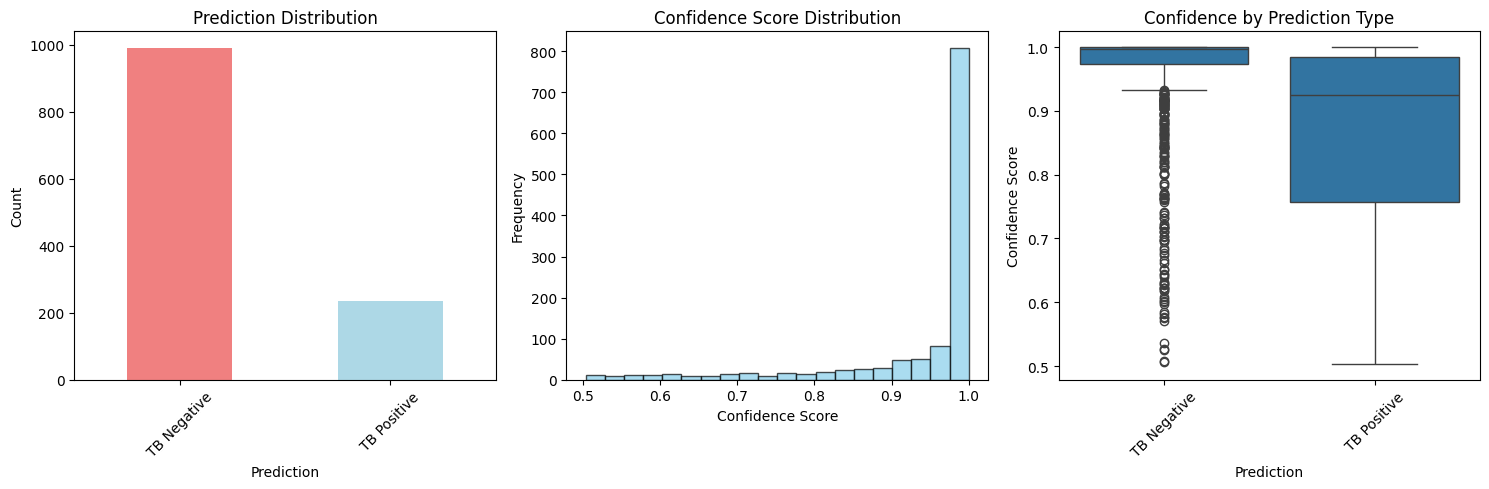

In [22]:
# Visualization of results
plt.figure(figsize=(15, 5))

# Plot 1: Prediction distribution
plt.subplot(1, 3, 1)
results_df['prediction'].value_counts().plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Prediction Distribution')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 2: Confidence distribution
plt.subplot(1, 3, 2)
plt.hist(results_df['confidence'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Confidence Score Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

# Plot 3: Confidence by prediction
plt.subplot(1, 3, 3)
sns.boxplot(data=results_df, x='prediction', y='confidence')
plt.title('Confidence by Prediction Type')
plt.xlabel('Prediction')
plt.ylabel('Confidence Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [21]:
# Save results to CSV for further analysis
results_df.to_csv('tb_detection_results.csv', index=False)
print("Results saved to 'tb_detection_results.csv'")

# Display sample of results
print("\nSample of detailed results:")
print(results_df.head(20))

Results saved to 'tb_detection_results.csv'

Sample of detailed results:
             filename   prediction  predicted_class  confidence
0   01-399-0231_3.wav  TB Negative                0    0.607624
1   01-399-0273_1.wav  TB Negative                0    0.970781
2   01-399-0802_0.wav  TB Negative                0    0.920175
3   01-399-0803_0.wav  TB Negative                0    0.920175
4   01-399-0803_1.wav  TB Negative                0    0.954268
5   01-399-0803_2.wav  TB Negative                0    0.864937
6   01-399-0803_3.wav  TB Negative                0    0.559479
7   01-399-0804_1.wav  TB Negative                0    0.610986
8   01-399-0804_2.wav  TB Positive                1    0.764035
9   01-399-0804_3.wav  TB Negative                0    0.898014
10  01-399-0805_0.wav  TB Negative                0    0.808585
11  01-399-0805_1.wav  TB Negative                0    0.579615
12  01-399-0805_2.wav  TB Negative                0    0.889936
13  01-399-0805_3.wav  TB Posit

## 11. Classification Metrics with Ground Truth

In [23]:
# Load metadata with ground truth labels
metadata = pd.read_csv('metadata_wavsonly.csv')
print(f"Metadata loaded: {len(metadata)} records")
print("Ground truth distribution:")
print(metadata['ground_truth_tb'].value_counts())

# Extract filename from path_file for matching
metadata['filename'] = metadata['path_file'].apply(lambda x: os.path.basename(x))

# Merge results with ground truth
merged_df = results_df.merge(metadata[['filename', 'ground_truth_tb']], on='filename', how='inner')
print(f"\nMatched {len(merged_df)} files with ground truth labels")

# Convert ground truth to match prediction format
y_true = merged_df['ground_truth_tb'].values
y_pred = merged_df['predicted_class'].values

print(f"\nGround Truth Distribution:")
print(f"TB Negative (0): {sum(y_true == 0)}")
print(f"TB Positive (1): {sum(y_true == 1)}")

print(f"\nPrediction Distribution:")
print(f"TB Negative (0): {sum(y_pred == 0)}")
print(f"TB Positive (1): {sum(y_pred == 1)}")

merged_df.head()

Metadata loaded: 1226 records
Ground truth distribution:
ground_truth_tb
0    1027
1     199
Name: count, dtype: int64

Matched 1226 files with ground truth labels

Ground Truth Distribution:
TB Negative (0): 1027
TB Positive (1): 199

Prediction Distribution:
TB Negative (0): 990
TB Positive (1): 236


,filename,prediction,predicted_class,confidence,ground_truth_tb
0,01-399-0231_3.wav,TB Negative,0,0.999692,1
1,01-399-0273_1.wav,TB Negative,0,0.999963,0
2,01-399-0802_0.wav,TB Positive,1,0.689628,0
3,01-399-0803_0.wav,TB Positive,1,0.689628,1
4,01-399-0803_1.wav,TB Negative,0,0.844652,1


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f} (TP/(TP+FP))")
print(f"Recall:    {recall:.4f} (TP/(TP+FN))")
print(f"F1-Score:  {f1:.4f}")

y_prob = merged_df['confidence'].values

y_prob_adjusted = np.where(y_pred == 1, y_prob, 1 - y_prob)
roc_auc = roc_auc_score(y_true, y_prob_adjusted)
print(f"ROC AUC:   {roc_auc:.4f}")

target_names = ['TB Negative', 'TB Positive']
print(classification_report(y_true, y_pred, target_names=target_names))

Accuracy:  0.7055
Precision: 0.1568 (TP/(TP+FP))
Recall:    0.1859 (TP/(TP+FN))
F1-Score:  0.1701
ROC AUC:   0.5153
              precision    recall  f1-score   support

 TB Negative       0.84      0.81      0.82      1027
 TB Positive       0.16      0.19      0.17       199

    accuracy                           0.71      1226
   macro avg       0.50      0.50      0.50      1226
weighted avg       0.73      0.71      0.72      1226



C:\Users\farras\AppData\Local\Temp\ipykernel_11968\2694810124.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_conf = merged_df.groupby('confidence_bin').apply(lambda x: accuracy_score(x['ground_truth_tb'], x['predicted_class']))
C:\Users\farras\AppData\Local\Temp\ipykernel_11968\2694810124.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_conf = merged_df.groupby('confidence_bin').apply(lambda x: accuracy_score(x['ground_truth_tb'], x['predicted_class']))


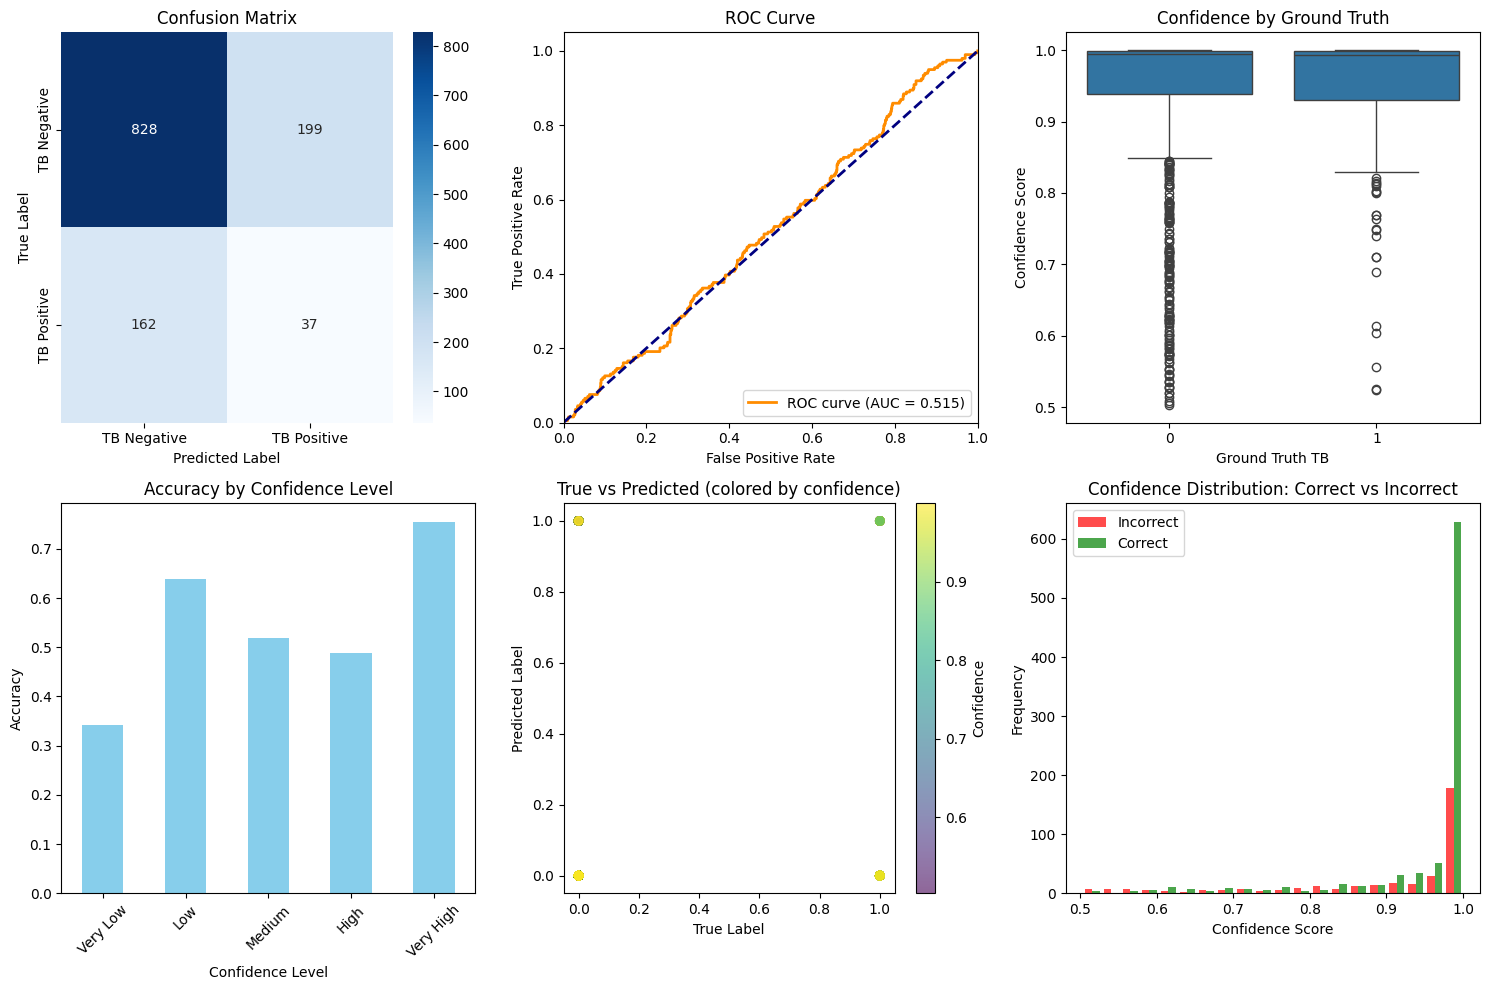

In [25]:
# Confusion Matrix Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Confusion Matrix
plt.subplot(2, 3, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 2: ROC Curve
plt.subplot(2, 3, 2)
fpr, tpr, thresholds = roc_curve(y_true, y_prob_adjusted)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot 3: Confidence distribution by ground truth
plt.subplot(2, 3, 3)
sns.boxplot(data=merged_df, x='ground_truth_tb', y='confidence')
plt.title('Confidence by Ground Truth')
plt.xlabel('Ground Truth TB')
plt.ylabel('Confidence Score')

# Plot 4: Prediction accuracy by confidence bins
plt.subplot(2, 3, 4)
merged_df['confidence_bin'] = pd.cut(merged_df['confidence'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
accuracy_by_conf = merged_df.groupby('confidence_bin').apply(lambda x: accuracy_score(x['ground_truth_tb'], x['predicted_class']))
accuracy_by_conf.plot(kind='bar', color='skyblue')
plt.title('Accuracy by Confidence Level')
plt.xlabel('Confidence Level')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Plot 5: True vs Predicted scatter
plt.subplot(2, 3, 5)
plt.scatter(y_true, y_pred, alpha=0.6, c=merged_df['confidence'], cmap='viridis')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('True vs Predicted (colored by confidence)')
plt.colorbar(label='Confidence')

# Plot 6: Error analysis
plt.subplot(2, 3, 6)
errors = merged_df[merged_df['ground_truth_tb'] != merged_df['predicted_class']]
correct = merged_df[merged_df['ground_truth_tb'] == merged_df['predicted_class']]
plt.hist([errors['confidence'], correct['confidence']], bins=20, alpha=0.7, 
         label=['Incorrect', 'Correct'], color=['red', 'green'])
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Distribution: Correct vs Incorrect')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
false_positives = merged_df[(merged_df['ground_truth_tb'] == 0) & (merged_df['predicted_class'] == 1)]
print(f"\nFalse Positives: {len(false_positives)}")
print("Top 10 False Positives (highest confidence):")
if len(false_positives) > 0:
    print(false_positives.nlargest(10, 'confidence')[['filename', 'confidence', 'ground_truth_tb', 'predicted_class']])

false_negatives = merged_df[(merged_df['ground_truth_tb'] == 1) & (merged_df['predicted_class'] == 0)]
print(f"\nFalse Negatives: {len(false_negatives)}")
print("Top 10 False Negatives (highest confidence):")
if len(false_negatives) > 0:
    print(false_negatives.nlargest(10, 'confidence')[['filename', 'confidence', 'ground_truth_tb', 'predicted_class']])

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
for threshold in thresholds:
    high_conf_mask = merged_df['confidence'] >= threshold
    high_conf_data = merged_df[high_conf_mask]
    
    if len(high_conf_data) > 0:
        acc = accuracy_score(high_conf_data['ground_truth_tb'], high_conf_data['predicted_class'])
        coverage = len(high_conf_data) / len(merged_df)
        print(f"Confidence >= {threshold}: Accuracy = {acc:.4f}, Coverage = {coverage:.4f} ({len(high_conf_data)}/{len(merged_df)} samples)")

merged_df.to_csv('tb_detection_evaluation_results.csv', index=False)
print(f"\nDetailed evaluation results saved to 'tb_detection_evaluation_results.csv'")

print(f"Total samples evaluated: {len(merged_df)}")
print(f"True Positives:  {sum((y_true == 1) & (y_pred == 1))}")
print(f"True Negatives:  {sum((y_true == 0) & (y_pred == 0))}")
print(f"False Positives: {sum((y_true == 0) & (y_pred == 1))}")
print(f"False Negatives: {sum((y_true == 1) & (y_pred == 0))}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {precision:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")

ERROR ANALYSIS

False Positives: 265
Top 10 False Positives (highest confidence):
               filename  confidence  ground_truth_tb  predicted_class
896   02-399-0743_0.wav    0.999425                0                1
230   01-399-0868_2.wav    0.999122                0                1
82    01-399-0825_3.wav    0.998520                0                1
159   01-399-0847_2.wav    0.997414                0                1
1091  02-399-0878_3.wav    0.997315                0                1
812   02-399-0716_0.wav    0.997239                0                1
535   01-399-0960_3.wav    0.997074                0                1
268   01-399-0882_0.wav    0.996543                0                1
227   01-399-0867_2.wav    0.995927                0                1
297   01-399-0889_3.wav    0.995617                0                1

False Negatives: 127
Top 10 False Negatives (highest confidence):
               filename  confidence  ground_truth_tb  predicted_class
697   01-39

# Train Ulang Model

## Dataset Preparation and Model Retraining

In [27]:
class CombinedDataset:
    def __init__(self, wav_transform, config):
        self.wav_transform = wav_transform
        self.config = config
        self.data = []
        self.labels = []
        
    def prepare_combined_dataset(self):
        metadata1 = pd.read_csv('metadata_wavsonly.csv')
        metadata2 = pd.read_csv('Forced_coughs.csv')
        
        found_files1 = 0
        missing_files1 = 0
        
        for _, row in metadata1.iterrows():
            # Gabungkan base path dengan path_file dari CSV
            wav_path = os.path.join('home/is/dwipraseetyo-a/NAS_HAI/Datasets/cidrz', row['path_file'])
            if os.path.exists(wav_path):
                label = int(row['ground_truth_tb'])
                self.data.append(wav_path)
                self.labels.append(label)
                found_files1 += 1
            else:
                missing_files1 += 1
        
        found_files2 = 0
        missing_files2 = 0
        
        for _, row in metadata2.iterrows():
            wav_filename = row['path'] + '.wav'
            wav_path = os.path.join('Audio_files_forced', wav_filename)
            if os.path.exists(wav_path):
                label = 1 if row['Label'] == 'TB' else 0
                self.data.append(wav_path)
                self.labels.append(label)
                found_files2 += 1
            else:
                missing_files2 += 1
        
        print(f"Dataset 1 (metadata_wavsonly.csv): {found_files1} found, {missing_files1} missing")
        print(f"Dataset 2 (Forced_coughs.csv): {found_files2} found, {missing_files2} missing")
        print(f"Total combined: {len(self.data)} files")
        
        return len(self.data)
    
    def preprocess_audio(self, wav_path):
        audio_data, sr = librosa.load(wav_path, sr=self.config.sampling_rate)
        
        cough_segments, _ = segment_cough(
            audio_data, 
            self.config.sampling_rate,
            self.config.cough_padding,
            self.config.min_cough_len,
            self.config.th_l_multiplier,
            self.config.th_h_multiplier
        )
        
        if len(cough_segments) > 0:
            audio_segment = cough_segments[0]
        else:
            audio_segment = audio_data
        
        audio_tensor = load_audio_sample(
            audio_segment, 
            self.config.sampling_rate, 
            self.config.desired_length, 
            self.config.fade_samples_ratio, 
            self.config.pad_types
        )
        
        mel_spec = self.wav_transform(audio_tensor.squeeze(0))
        mel_spec = mel_spec.transpose(0, 1)
        
        return mel_spec
    
    def get_batch(self, indices):
        batch_data = []
        batch_labels = []
        
        for idx in indices:
            try:
                mel_spec = self.preprocess_audio(self.data[idx])
                batch_data.append(mel_spec)
                batch_labels.append(self.labels[idx])
            except:
                continue
        
        if len(batch_data) == 0:
            return None, None
        
        batch_data = torch.stack(batch_data).to(device)
        batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)
        
        return batch_data, batch_labels

dataset = CombinedDataset(wav_transform, config)
total_samples = dataset.prepare_combined_dataset()

tb_count = sum(dataset.labels)
ntb_count = len(dataset.labels) - tb_count

print(f"Combined dataset prepared:")
print(f"Total samples: {total_samples}")
print(f"TB samples: {tb_count}")
print(f"Non-TB samples: {ntb_count}")
print(f"Class balance: {tb_count/total_samples:.3f} TB, {ntb_count/total_samples:.3f} Non-TB")

Dataset 1 (metadata_wavsonly.csv): 1226 found, 0 missing
Dataset 2 (Forced_coughs.csv): 1018 found, 207 missing
Total combined: 2244 files
Combined dataset prepared:
Total samples: 2244
TB samples: 1039
Non-TB samples: 1205
Class balance: 0.463 TB, 0.537 Non-TB


In [58]:
class TrainingConfig:
    def __init__(self):
        self.learning_rate = 0.001
        self.batch_size = 16
        self.num_epochs = 50
        self.patience = 10
        self.weight_decay = 1e-4
        self.model_save_path = "best_pool2.pth"
        self.config_save_path = "best_config2.json"

class ModelTrainer:
    def __init__(self, model, dataset, train_config):
        self.model = model
        self.dataset = dataset
        self.config = train_config
        self.optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=train_config.learning_rate,
            weight_decay=train_config.weight_decay
        )
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.5
        )
        
    def train_epoch(self, indices):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        np.random.shuffle(indices)
        
        for i in range(0, len(indices), self.config.batch_size):
            batch_indices = indices[i:i + self.config.batch_size]
            batch_data, batch_labels = self.dataset.get_batch(batch_indices)
            
            if batch_data is None:
                continue
            
            self.optimizer.zero_grad()
            outputs = self.model(batch_data)
            loss = self.criterion(outputs, batch_labels)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
        
        return total_loss / (len(indices) // self.config.batch_size), correct / total
    
    def validate(self, indices):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for i in range(0, len(indices), self.config.batch_size):
                batch_indices = indices[i:i + self.config.batch_size]
                batch_data, batch_labels = self.dataset.get_batch(batch_indices)
                
                if batch_data is None:
                    continue
                
                outputs = self.model(batch_data)
                loss = self.criterion(outputs, batch_labels)
                
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
        
        return total_loss / (len(indices) // self.config.batch_size), correct / total
    
    def train(self):
        indices = list(range(len(self.dataset.data)))
        np.random.shuffle(indices)
        
        train_size = int(0.8 * len(indices))
        train_indices = indices[:train_size]
        val_indices = indices[train_size:]
        
        best_val_acc = 0
        patience_counter = 0
        
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        
        for epoch in range(self.config.num_epochs):
            train_loss, train_acc = self.train_epoch(train_indices)
            val_loss, val_acc = self.validate(val_indices)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            
            self.scheduler.step(val_loss)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                self.save_model()
            else:
                patience_counter += 1
            
            if epoch % 5 == 0:
                print(f"Epoch {epoch+1}/{self.config.num_epochs}")
                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
                print(f"Best Val Acc: {best_val_acc:.4f}")
                
            if patience_counter >= self.config.patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'best_val_acc': best_val_acc
        }
    
    def save_model(self):
        torch.save({
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'config': {
                'input_size': config.input_size,
                'hidden_size': config.hidden_size,
                'output_size': config.output_size,
                'dropout': config.dropout
            }
        }, self.config.model_save_path)

train_config = TrainingConfig()

new_model = LSTMAudioClassifier(
    input_size=config.input_size,
    hidden_size=config.hidden_size,
    output_size=config.output_size,
    dropout=config.dropout
).to(device)

trainer = ModelTrainer(new_model, dataset, train_config)

Epoch 1/50
Train Loss: 0.5469, Train Acc: 0.7868
Val Loss: 0.4427, Val Acc: 0.8292
Best Val Acc: 0.8292
Epoch 6/50
Train Loss: 0.4645, Train Acc: 0.8250
Val Loss: 0.4369, Val Acc: 0.8292
Best Val Acc: 0.8639
Epoch 6/50
Train Loss: 0.4645, Train Acc: 0.8250
Val Loss: 0.4369, Val Acc: 0.8292
Best Val Acc: 0.8639
Epoch 11/50
Train Loss: 0.5233, Train Acc: 0.7880
Val Loss: 0.4032, Val Acc: 0.8663
Best Val Acc: 0.8663
Epoch 11/50
Train Loss: 0.5233, Train Acc: 0.7880
Val Loss: 0.4032, Val Acc: 0.8663
Best Val Acc: 0.8663
Epoch 16/50
Train Loss: 0.4580, Train Acc: 0.8312
Val Loss: 0.4156, Val Acc: 0.8663
Best Val Acc: 0.8663
Epoch 16/50
Train Loss: 0.4580, Train Acc: 0.8312
Val Loss: 0.4156, Val Acc: 0.8663
Best Val Acc: 0.8663
Early stopping at epoch 17

Training completed!
Best validation accuracy: 0.8663
Early stopping at epoch 17

Training completed!
Best validation accuracy: 0.8663


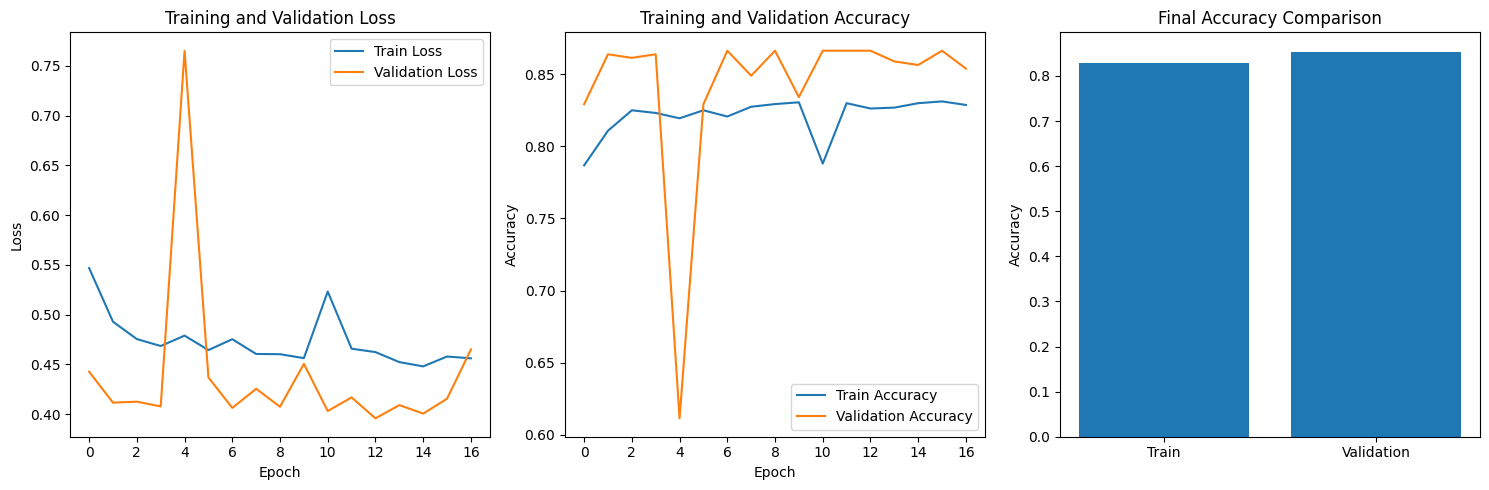

Model saved to: best_pool2.pth
Configuration saved to: best_config2.json


In [59]:
training_results = trainer.train()

print(f"\nTraining completed!")
print(f"Best validation accuracy: {training_results['best_val_acc']:.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(training_results['train_losses'], label='Train Loss')
plt.plot(training_results['val_losses'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(training_results['train_accs'], label='Train Accuracy')
plt.plot(training_results['val_accs'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.bar(['Train', 'Validation'], 
        [training_results['train_accs'][-1], training_results['val_accs'][-1]])
plt.title('Final Accuracy Comparison')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

config_data = {
    'model_architecture': {
        'input_size': config.input_size,
        'hidden_size': config.hidden_size,
        'output_size': config.output_size,
        'dropout': config.dropout
    },
    'audio_processing': {
        'sampling_rate': config.sampling_rate,
        'desired_length': config.desired_length,
        'n_mel_channels': config.n_mel_channels,
        'filter_length': config.filter_length,
        'hop_length': config.hop_length,
        'win_length': config.win_length
    },
    'training_config': {
        'learning_rate': train_config.learning_rate,
        'batch_size': train_config.batch_size,
        'num_epochs': train_config.num_epochs,
        'weight_decay': train_config.weight_decay
    },
    'dataset_info': {
        'total_samples': total_samples,
        'tb_samples': tb_count,
        'ntb_samples': ntb_count,
        'class_balance': tb_count/total_samples
    },
    'training_results': {
        'best_val_acc': training_results['best_val_acc'],
        'final_train_acc': training_results['train_accs'][-1],
        'final_val_acc': training_results['val_accs'][-1]
    }
}

with open(train_config.config_save_path, 'w') as f:
    json.dump(config_data, f, indent=2)

print(f"Model saved to: {train_config.model_save_path}")
print(f"Configuration saved to: {train_config.config_save_path}")

In [28]:
trained_model = LSTMAudioClassifier(
    input_size=config.input_size,
    hidden_size=config.hidden_size,
    output_size=config.output_size,
    dropout=config.dropout
).to(device)

checkpoint = torch.load(train_config.model_save_path, map_location=device)
trained_model.load_state_dict(checkpoint['model'])
trained_model.eval()

def predict_tb_new(wav_path):
    audio_data, sr = librosa.load(wav_path, sr=config.sampling_rate)
    
    cough_segments, cough_mask = segment_cough(
        audio_data, 
        config.sampling_rate,
        config.cough_padding,
        config.min_cough_len,
        config.th_l_multiplier,
        config.th_h_multiplier
    )
    
    if len(cough_segments) > 0:
        audio_segment = cough_segments[0]
    else:
        audio_segment = audio_data
    
    audio_tensor = load_audio_sample(
        audio_segment, 
        config.sampling_rate, 
        config.desired_length, 
        config.fade_samples_ratio, 
        config.pad_types
    )
    
    # Normalize audio to [-1, 1] range to avoid assertion error
    audio_tensor = torch.clamp(audio_tensor, -1.0, 1.0)
    
    mel_spec = wav_transform(audio_tensor.squeeze(0))
    mel_spec = mel_spec.unsqueeze(0).transpose(1, 2)
    mel_spec = mel_spec.to(device)
    
    with torch.no_grad():
        output = trained_model(mel_spec)
        prediction = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(prediction, dim=1).item()
        confidence = prediction[0][predicted_class].item()
    
    result = "TB Positive" if predicted_class == 1 else "TB Negative"
    return result, confidence

test_indices = np.random.choice(len(dataset.data), size=10, replace=False)

print("Testing new model on random samples:")
correct_predictions = 0

for idx in test_indices:
    wav_path = dataset.data[idx]
    true_label = dataset.labels[idx]
    
    try:
        result, confidence = predict_tb_new(wav_path)
        predicted_label = 1 if result == "TB Positive" else 0
        
        is_correct = predicted_label == true_label
        correct_predictions += is_correct
        
        filename = os.path.basename(wav_path)
        true_str = "TB" if true_label == 1 else "NTB"
        status = "✓" if is_correct else "✗"
        
        print(f"{status} {filename}: {result} (conf: {confidence:.3f}) | True: {true_str}")
        
    except Exception as e:
        print(f"Error testing {wav_path}: {e}")

test_accuracy = correct_predictions / len(test_indices)
print(f"\nTest accuracy on {len(test_indices)} samples: {test_accuracy:.3f}")

print(f"\nModel retraining summary:")
print(f"- Dataset: {total_samples} samples ({tb_count} TB, {ntb_count} Non-TB)")
print(f"- Best validation accuracy: {training_results['best_val_acc']:.4f}")
print(f"- Model saved: {train_config.model_save_path}")
print(f"- Config saved: {train_config.config_save_path}")

NameError: name 'train_config' is not defined

## Evaluasi Model baru

In [29]:
# Comprehensive evaluation of the new retrained model on validation set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Model trained on {total_samples} samples ({tb_count} TB, {ntb_count} Non-TB)")
print(f"Training completed with best validation accuracy: {training_results['best_val_acc']:.4f}")

# Create a test set from the dataset (20% of data)
np.random.seed(42)  # For reproducible results
all_indices = list(range(len(dataset.data)))
np.random.shuffle(all_indices)

# Use the same split as training (80% train, 20% test)
train_size = int(0.8 * len(all_indices))
test_indices = all_indices[train_size:]

print(f"\nEvaluating on test set: {len(test_indices)} samples")

# Collect predictions on test set
test_predictions = []
test_confidences = []
test_true_labels = []
test_filenames = []

print("Making predictions on test set...")
for i, idx in enumerate(test_indices):
    wav_path = dataset.data[idx]
    true_label = dataset.labels[idx]
    
    try:
        result, confidence = predict_tb_new(wav_path)
        predicted_label = 1 if result == "TB Positive" else 0
        
        test_predictions.append(predicted_label)
        test_confidences.append(confidence)
        test_true_labels.append(true_label)
        test_filenames.append(os.path.basename(wav_path))
        
        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{len(test_indices)} test samples")
            
    except Exception as e:
        print(f"Error processing {wav_path}: {e}")
        continue

print(f"Successfully processed {len(test_predictions)} test samples")

Model trained on 2244 samples (1039 TB, 1205 Non-TB)


NameError: name 'training_results' is not defined

In [ ]:
# Calculate comprehensive metrics
y_true_test = np.array(test_true_labels)
y_pred_test = np.array(test_predictions)
y_conf_test = np.array(test_confidences)

test_accuracy = accuracy_score(y_true_test, y_pred_test)
test_precision = precision_score(y_true_test, y_pred_test)
test_recall = recall_score(y_true_test, y_pred_test)
test_f1 = f1_score(y_true_test, y_pred_test)

y_prob_adjusted = np.where(y_pred_test == 1, y_conf_test, 1 - y_conf_test)
test_roc_auc = roc_auc_score(y_true_test, y_prob_adjusted)

print(f"Test Accuracy:  {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f} (TP/(TP+FP))")
print(f"Test Recall:    {test_recall:.4f} (TP/(TP+FN)) - Sensitivity")
print(f"Test F1-Score:  {test_f1:.4f}")
print(f"Test ROC AUC:   {test_roc_auc:.4f}")

cm = confusion_matrix(y_true_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn) 
ppv = tp / (tp + fp)  
npv = tn / (tn + fn)

print(f"\nDetailed Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity:          {specificity:.4f}")
print(f"PPV (Precision):      {ppv:.4f}")
print(f"NPV:                  {npv:.4f}")

print(f"\nConfusion Matrix:")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")

print(f"\nClass Distribution:")
print(f"True TB cases:      {sum(y_true_test)} ({sum(y_true_test)/len(y_true_test)*100:.1f}%)")
print(f"True Non-TB cases:  {len(y_true_test) - sum(y_true_test)} ({(len(y_true_test) - sum(y_true_test))/len(y_true_test)*100:.1f}%)")

target_names = ['TB Negative', 'TB Positive']
print(f"\nClassification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=target_names))

=== NEW MODEL PERFORMANCE METRICS ===
Test Accuracy:  0.8429
Test Precision: 0.8153 (TP/(TP+FP))
Test Recall:    0.7901 (TP/(TP+FN)) - Sensitivity
Test F1-Score:  0.8025
Test ROC AUC:   0.8696

Detailed Metrics:
Sensitivity (Recall): 0.7901
Specificity:          0.8787
PPV (Precision):      0.8153
NPV:                  0.8607

Confusion Matrix:
True Negatives:  210
False Positives: 29
False Negatives: 34
True Positives:  128

Class Distribution:
True TB cases:      162 (40.4%)
True Non-TB cases:  239 (59.6%)

Classification Report:
              precision    recall  f1-score   support

 TB Negative       0.86      0.88      0.87       239
 TB Positive       0.82      0.79      0.80       162

    accuracy                           0.84       401
   macro avg       0.84      0.83      0.84       401
weighted avg       0.84      0.84      0.84       401



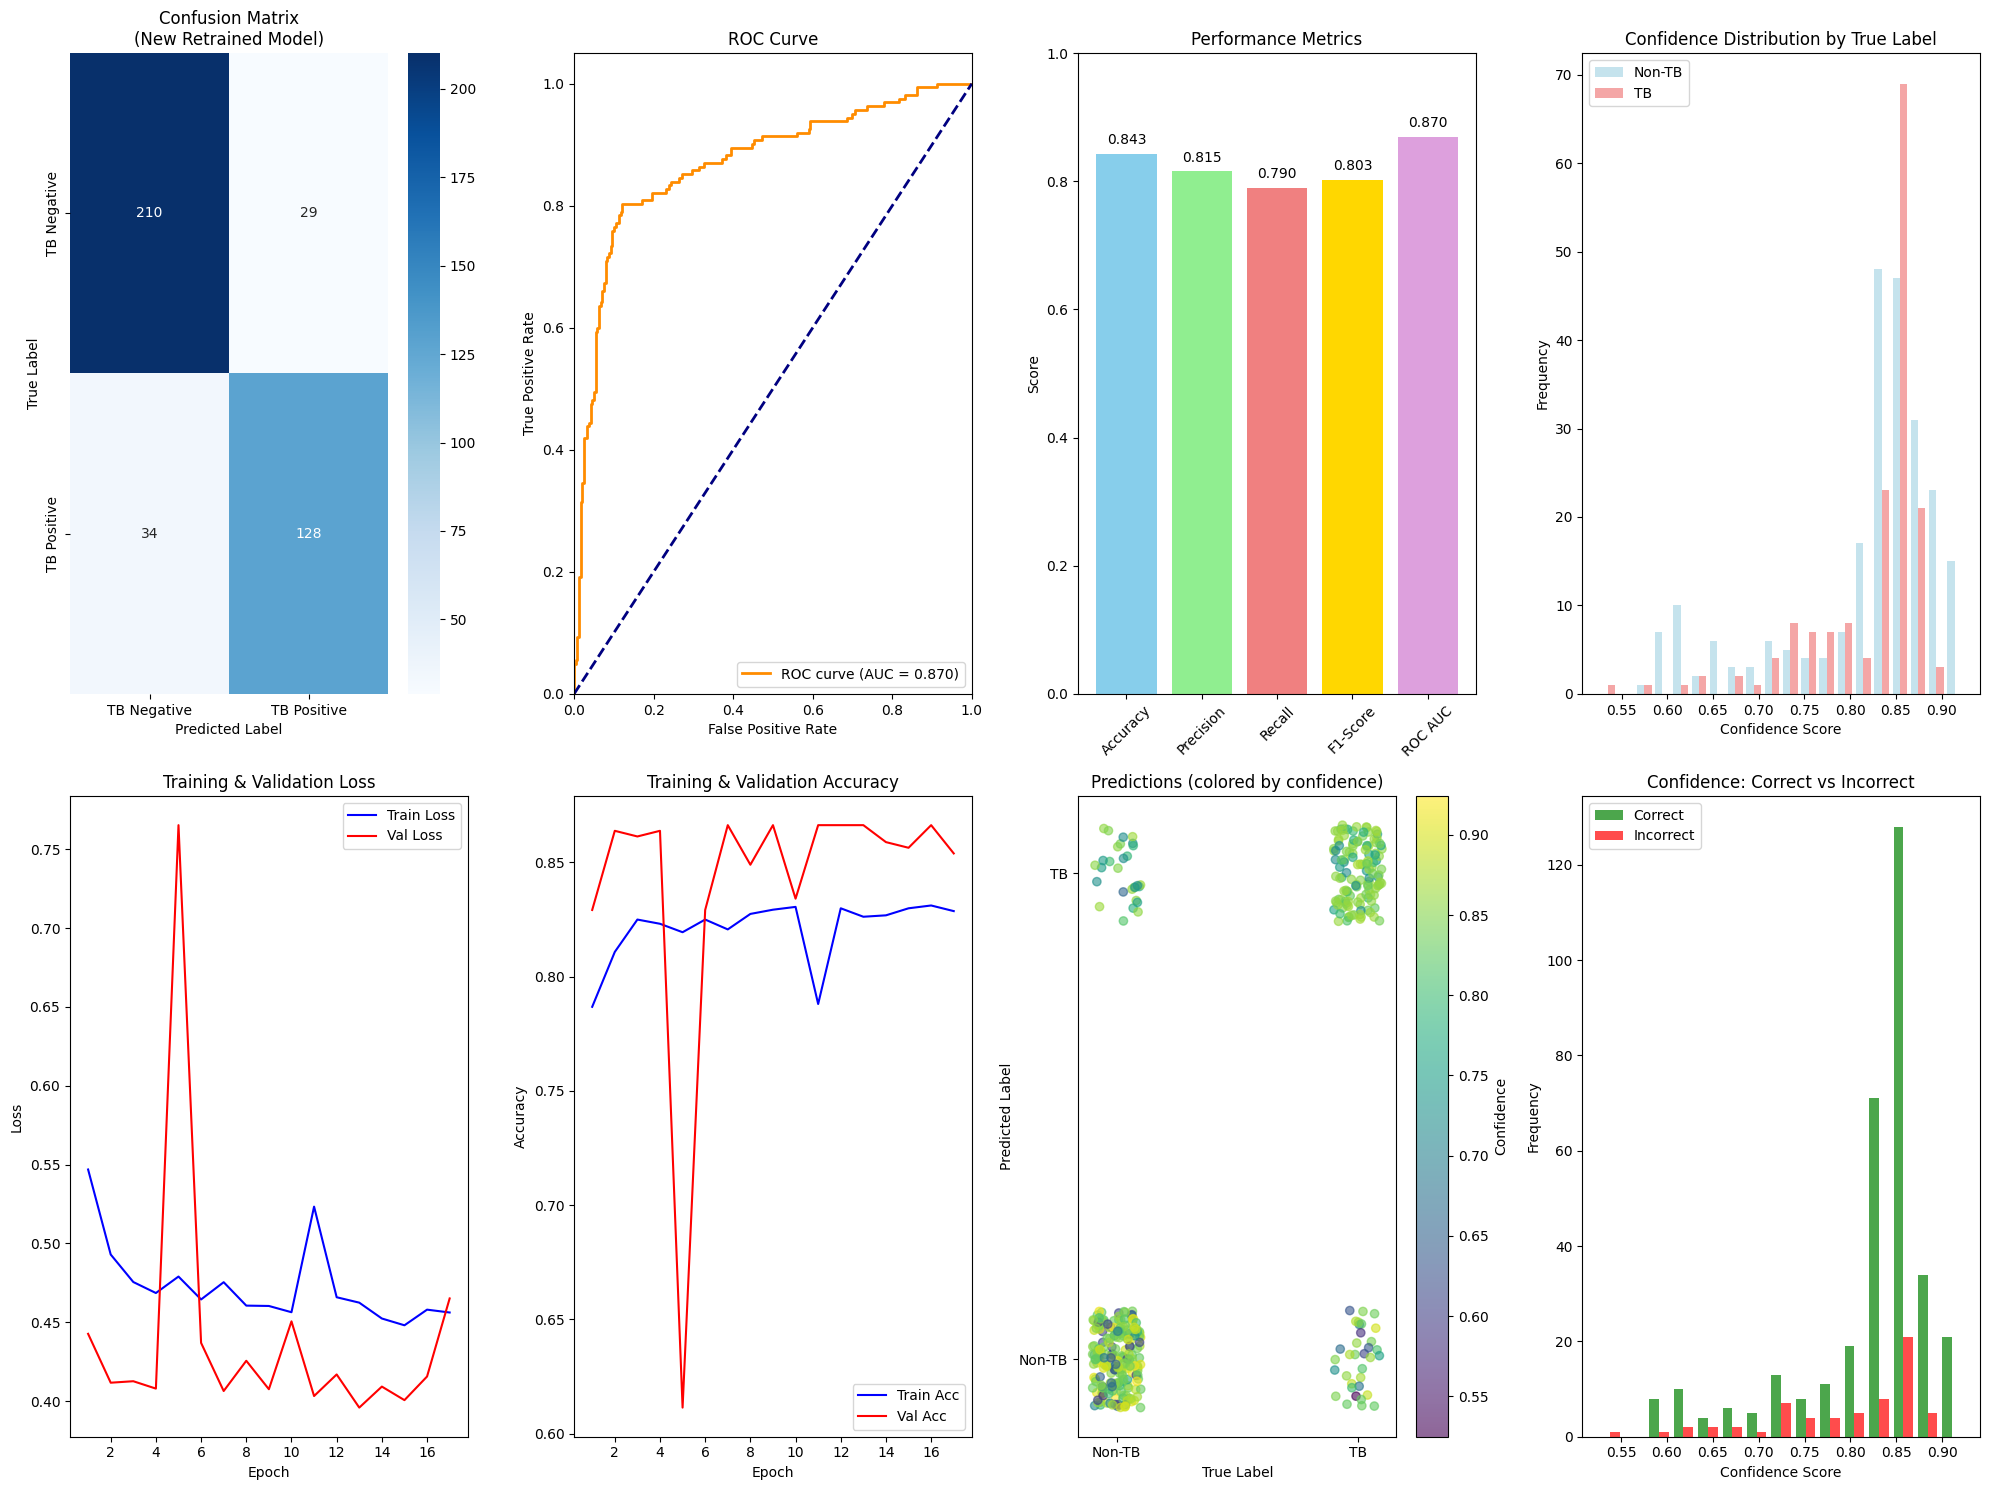

Dataset Size: 2244 samples (vs previous smaller dataset)
Class Balance: 0.463 TB, 0.537 Non-TB
Training Best Val Acc: 0.8663
Test Performance:
  - Accuracy:  0.8429
  - Precision: 0.8153
  - Recall:    0.7901
  - F1-Score:  0.8025
  - ROC AUC:   0.8696


In [69]:
# Comprehensive visualization of new model performance
plt.figure(figsize=(20, 15))

# Plot 1: Confusion Matrix
plt.subplot(2, 4, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix\n(New Retrained Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 2: ROC Curve
plt.subplot(2, 4, 2)
fpr, tpr, thresholds = roc_curve(y_true_test, y_prob_adjusted)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot 3: Metrics Comparison
plt.subplot(2, 4, 3)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
values = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc]
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.ylim([0, 1])
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')
plt.xticks(rotation=45)

# Plot 4: Confidence Distribution by True Label
plt.subplot(2, 4, 4)
tb_confidences = [y_conf_test[i] for i in range(len(y_true_test)) if y_true_test[i] == 1]
ntb_confidences = [y_conf_test[i] for i in range(len(y_true_test)) if y_true_test[i] == 0]
plt.hist([ntb_confidences, tb_confidences], bins=20, alpha=0.7, 
         label=['Non-TB', 'TB'], color=['lightblue', 'lightcoral'])
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Distribution by True Label')
plt.legend()

# Plot 5: Training History
plt.subplot(2, 4, 5)
epochs = range(1, len(training_results['train_losses']) + 1)
plt.plot(epochs, training_results['train_losses'], 'b-', label='Train Loss')
plt.plot(epochs, training_results['val_losses'], 'r-', label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot 6: Accuracy History
plt.subplot(2, 4, 6)
plt.plot(epochs, training_results['train_accs'], 'b-', label='Train Acc')
plt.plot(epochs, training_results['val_accs'], 'r-', label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 4, 7)

jitter = 0.1
x_jittered = y_true_test + np.random.uniform(-jitter, jitter, len(y_true_test))
y_jittered = y_pred_test + np.random.uniform(-jitter, jitter, len(y_pred_test))
scatter = plt.scatter(x_jittered, y_jittered, alpha=0.6, c=y_conf_test, cmap='viridis')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Predictions (colored by confidence)')
plt.colorbar(scatter, label='Confidence')
plt.xticks([0, 1], ['Non-TB', 'TB'])
plt.yticks([0, 1], ['Non-TB', 'TB'])

# Plot 8: Error Analysis
plt.subplot(2, 4, 8)
correct_mask = y_true_test == y_pred_test
correct_conf = y_conf_test[correct_mask]
incorrect_conf = y_conf_test[~correct_mask]
plt.hist([correct_conf, incorrect_conf], bins=15, alpha=0.7, 
         label=['Correct', 'Incorrect'], color=['green', 'red'])
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence: Correct vs Incorrect')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Dataset Size: {total_samples} samples (vs previous smaller dataset)")
print(f"Class Balance: {tb_count/total_samples:.3f} TB, {ntb_count/total_samples:.3f} Non-TB")
print(f"Training Best Val Acc: {training_results['best_val_acc']:.4f}")
print(f"Test Performance:")
print(f"  - Accuracy:  {test_accuracy:.4f}")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall:    {test_recall:.4f}")
print(f"  - F1-Score:  {test_f1:.4f}")
print(f"  - ROC AUC:   {test_roc_auc:.4f}")


In [68]:
# Additional analysis: Performance by confidence thresholds
print("PERFORMANCE BY CONFIDENCE THRESHOLDS")
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for threshold in thresholds:
    high_conf_mask = y_conf_test >= threshold
    if np.sum(high_conf_mask) > 0:
        high_conf_true = y_true_test[high_conf_mask]
        high_conf_pred = y_pred_test[high_conf_mask]
        
        acc = accuracy_score(high_conf_true, high_conf_pred)
        coverage = np.sum(high_conf_mask) / len(y_true_test)
        
        print(f"Confidence >= {threshold}: Accuracy = {acc:.4f}, Coverage = {coverage:.4f} ({np.sum(high_conf_mask)}/{len(y_true_test)} samples)")

# Error analysis with file details
print(f"\nERROR ANALYSIS")

# False Positives (Predicted TB, Actually Non-TB)
fp_indices = np.where((y_true_test == 0) & (y_pred_test == 1))[0]
print(f"False Positives: {len(fp_indices)}")
if len(fp_indices) > 0:
    print("Top 5 False Positives (highest confidence):")
    fp_conf_sorted = sorted([(i, y_conf_test[i]) for i in fp_indices], key=lambda x: x[1], reverse=True)
    for i, (idx, conf) in enumerate(fp_conf_sorted[:5]):
        filename = test_filenames[idx]
        print(f"  {i+1}. {filename}: Confidence = {conf:.3f}")

# False Negatives (Predicted Non-TB, Actually TB)
fn_indices = np.where((y_true_test == 1) & (y_pred_test == 0))[0]
print(f"\nFalse Negatives: {len(fn_indices)}")
if len(fn_indices) > 0:
    print("Top 5 False Negatives (highest confidence):")
    fn_conf_sorted = sorted([(i, y_conf_test[i]) for i in fn_indices], key=lambda x: x[1], reverse=True)
    for i, (idx, conf) in enumerate(fn_conf_sorted[:5]):
        filename = test_filenames[idx]
        print(f"  {i+1}. {filename}: Confidence = {conf:.3f}")

results_df_new = pd.DataFrame({
    'filename': test_filenames,
    'true_label': y_true_test,
    'predicted_label': y_pred_test,
    'confidence': y_conf_test,
    'correct': y_true_test == y_pred_test
})

results_df_new.to_csv('new_model_test_results.csv', index=False)
print(f"Total test samples: {len(results_df_new)}")
print(f"Correct predictions: {sum(results_df_new['correct'])} ({sum(results_df_new['correct'])/len(results_df_new)*100:.1f}%)")
print(f"Incorrect predictions: {len(results_df_new) - sum(results_df_new['correct'])} ({(len(results_df_new) - sum(results_df_new['correct']))/len(results_df_new)*100:.1f}%)")

PERFORMANCE BY CONFIDENCE THRESHOLDS
Confidence >= 0.5: Accuracy = 0.8429, Coverage = 1.0000 (401/401 samples)
Confidence >= 0.6: Accuracy = 0.8456, Coverage = 0.9850 (395/401 samples)
Confidence >= 0.7: Accuracy = 0.8504, Coverage = 0.9002 (361/401 samples)
Confidence >= 0.8: Accuracy = 0.8721, Coverage = 0.7606 (305/401 samples)
Confidence >= 0.9: Accuracy = 1.0000, Coverage = 0.0424 (17/401 samples)

ERROR ANALYSIS
False Positives: 29
Top 5 False Positives (highest confidence):
  1. PID_82C_7_pixel.wav: Confidence = 0.866
  2. PID_82C_8_pixel.wav: Confidence = 0.866
  3. PID_82C_6_pixel.wav: Confidence = 0.865
  4. PID_82C_1_pixel.wav: Confidence = 0.862
  5. PID_80C_19_codec.wav: Confidence = 0.858

False Negatives: 34
Top 5 False Negatives (highest confidence):
  1. 01-399-0860_1.wav: Confidence = 0.897
  2. 01-399-0947_3.wav: Confidence = 0.889
  3. 01-399-0981_2.wav: Confidence = 0.887
  4. 02-399-0774_0.wav: Confidence = 0.878
  5. 01-399-1004_1.wav: Confidence = 0.874
Total te

## 15. MFCC-Based Model Implementation

In [80]:
class MFCCProcessor:
    def __init__(self, config):
        self.config = config
        self.n_mfcc = 13
        self.n_mels = 40
        
    def extract_mfcc(self, audio_data, sr):
        mfcc_features = librosa.feature.mfcc(
            y=audio_data,
            sr=sr,
            n_mfcc=self.n_mfcc,
            n_mels=self.n_mels,
            n_fft=self.config.filter_length,
            hop_length=self.config.hop_length,
            win_length=self.config.win_length,
            fmin=self.config.mel_fmin,
            fmax=self.config.mel_fmax
        )
        
        delta_mfcc = librosa.feature.delta(mfcc_features)
        delta2_mfcc = librosa.feature.delta(mfcc_features, order=2)
        
        combined_features = np.vstack([mfcc_features, delta_mfcc, delta2_mfcc])
        return combined_features.T
    
    def preprocess_audio(self, wav_path):
        audio_data, sr = librosa.load(wav_path, sr=self.config.sampling_rate)
        
        audio_max = np.abs(audio_data).max()
        if audio_max > 0:
            audio_data = audio_data / audio_max
        
        cough_segments, _ = segment_cough(
            audio_data, 
            self.config.sampling_rate,
            self.config.cough_padding,
            self.config.min_cough_len,
            self.config.th_l_multiplier,
            self.config.th_h_multiplier
        )
        
        if len(cough_segments) > 0:
            audio_segment = cough_segments[0]
        else:
            audio_segment = audio_data
        
        if len(audio_segment) < 1000:
            audio_segment = audio_data
        
        audio_tensor = load_audio_sample(
            audio_segment, 
            self.config.sampling_rate, 
            self.config.desired_length, 
            self.config.fade_samples_ratio, 
            self.config.pad_types
        )
        
        mfcc_features = self.extract_mfcc(audio_tensor.squeeze().numpy(), self.config.sampling_rate)
        return torch.tensor(mfcc_features, dtype=torch.float32)

class LSTMAudioClassifierMFCC(nn.Module):
    def __init__(self, input_size=39, hidden_size=512, output_size=2, dropout=0.1):
        super(LSTMAudioClassifierMFCC, self).__init__()
        
        self.batch_norm1 = nn.BatchNorm1d(input_size)
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.batch_norm1(x)
        x = x.transpose(1, 2)
        x, _ = self.lstm1(x)
        
        x = x.transpose(1, 2)
        x = self.batch_norm2(x)
        x = x.transpose(1, 2)
        x, _ = self.lstm2(x)

        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x

class MFCCDataset:
    def __init__(self, mfcc_processor, config):
        self.mfcc_processor = mfcc_processor
        self.config = config
        self.data = []
        self.labels = []
        
    def prepare_dataset(self):
        metadata1 = pd.read_csv('metadata_wavsonly.csv')
        metadata2 = pd.read_csv('Forced_coughs.csv')
        
        for _, row in metadata1.iterrows():
            wav_path = os.path.join('home/is/dwipraseetyo-a/NAS_HAI/Datasets/cidrz', row['path_file'])
            if os.path.exists(wav_path):
                label = int(row['ground_truth_tb'])
                self.data.append(wav_path)
                self.labels.append(label)
        
        for _, row in metadata2.iterrows():
            wav_filename = row['path'] + '.wav'
            wav_path = os.path.join('Audio_files_forced', wav_filename)
            if os.path.exists(wav_path):
                label = 1 if row['Label'] == 'TB' else 0
                self.data.append(wav_path)
                self.labels.append(label)
        
        return len(self.data)
    
    def get_batch(self, indices):
        batch_data = []
        batch_labels = []
        
        for idx in indices:
            try:
                mfcc_features = self.mfcc_processor.preprocess_audio(self.data[idx])
                batch_data.append(mfcc_features)
                batch_labels.append(self.labels[idx])
            except:
                continue
        
        if len(batch_data) == 0:
            return None, None
        
        batch_data = torch.stack(batch_data).to(device)
        batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)
        
        return batch_data, batch_labels

class MFCCTrainingConfig:
    def __init__(self):
        self.learning_rate = 0.001
        self.batch_size = 16
        self.num_epochs = 50
        self.patience = 10
        self.weight_decay = 1e-4
        self.model_save_path = "best_mfcc_model.pth"
        self.config_save_path = "best_mfcc_config.json"

class MFCCModelTrainer:
    def __init__(self, model, dataset, train_config):
        self.model = model
        self.dataset = dataset
        self.config = train_config
        self.optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=train_config.learning_rate,
            weight_decay=train_config.weight_decay
        )
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.5
        )
        
    def train_epoch(self, indices):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        np.random.shuffle(indices)
        
        for i in range(0, len(indices), self.config.batch_size):
            batch_indices = indices[i:i + self.config.batch_size]
            batch_data, batch_labels = self.dataset.get_batch(batch_indices)
            
            if batch_data is None:
                continue
            
            self.optimizer.zero_grad()
            outputs = self.model(batch_data)
            loss = self.criterion(outputs, batch_labels)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
        
        return total_loss / (len(indices) // self.config.batch_size), correct / total
    
    def validate(self, indices):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for i in range(0, len(indices), self.config.batch_size):
                batch_indices = indices[i:i + self.config.batch_size]
                batch_data, batch_labels = self.dataset.get_batch(batch_indices)
                
                if batch_data is None:
                    continue
                
                outputs = self.model(batch_data)
                loss = self.criterion(outputs, batch_labels)
                
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
        
        return total_loss / (len(indices) // self.config.batch_size), correct / total
    
    def train(self):
        indices = list(range(len(self.dataset.data)))
        np.random.shuffle(indices)
        
        train_size = int(0.8 * len(indices))
        train_indices = indices[:train_size]
        val_indices = indices[train_size:]
        
        best_val_acc = 0
        patience_counter = 0
        
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        
        for epoch in range(self.config.num_epochs):
            train_loss, train_acc = self.train_epoch(train_indices)
            val_loss, val_acc = self.validate(val_indices)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            
            self.scheduler.step(val_loss)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                self.save_model()
            else:
                patience_counter += 1
                
            if patience_counter >= self.config.patience:
                break
        
        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'best_val_acc': best_val_acc
        }
    
    def save_model(self):
        torch.save({
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'config': {
                'input_size': 39,
                'hidden_size': 512,
                'output_size': 2,
                'dropout': 0.1
            }
        }, self.config.model_save_path)

In [81]:
mfcc_processor = MFCCProcessor(config)
mfcc_dataset = MFCCDataset(mfcc_processor, config)
mfcc_total_samples = mfcc_dataset.prepare_dataset()

mfcc_tb_count = sum(mfcc_dataset.labels)
mfcc_ntb_count = len(mfcc_dataset.labels) - mfcc_tb_count

mfcc_model = LSTMAudioClassifierMFCC(
    input_size=39,
    hidden_size=512,
    output_size=2,
    dropout=0.1
).to(device)

mfcc_train_config = MFCCTrainingConfig()
mfcc_trainer = MFCCModelTrainer(mfcc_model, mfcc_dataset, mfcc_train_config)

mfcc_training_results = mfcc_trainer.train()

mfcc_config_data = {
    'model_architecture': {
        'input_size': 39,
        'hidden_size': 512,
        'output_size': 2,
        'dropout': 0.1,
        'feature_type': 'MFCC+Delta+Delta-Delta'
    },
    'audio_processing': {
        'sampling_rate': config.sampling_rate,
        'desired_length': config.desired_length,
        'n_mfcc': 13,
        'n_mels': 40,
        'filter_length': config.filter_length,
        'hop_length': config.hop_length,
        'win_length': config.win_length
    },
    'training_config': {
        'learning_rate': mfcc_train_config.learning_rate,
        'batch_size': mfcc_train_config.batch_size,
        'num_epochs': mfcc_train_config.num_epochs,
        'weight_decay': mfcc_train_config.weight_decay
    },
    'dataset_info': {
        'total_samples': mfcc_total_samples,
        'tb_samples': mfcc_tb_count,
        'ntb_samples': mfcc_ntb_count,
        'class_balance': mfcc_tb_count/mfcc_total_samples
    },
    'training_results': {
        'best_val_acc': mfcc_training_results['best_val_acc'],
        'final_train_acc': mfcc_training_results['train_accs'][-1],
        'final_val_acc': mfcc_training_results['val_accs'][-1]
    }
}

with open(mfcc_train_config.config_save_path, 'w') as f:
    json.dump(mfcc_config_data, f, indent=2)

In [84]:
def predict_tb_mfcc(wav_path):
    mfcc_model.eval()
    
    audio_data, sr = librosa.load(wav_path, sr=config.sampling_rate)
    
    audio_max = np.abs(audio_data).max()
    if audio_max > 0:
        audio_data = audio_data / audio_max
    
    cough_segments, _ = segment_cough(
        audio_data, 
        config.sampling_rate,
        config.cough_padding,
        config.min_cough_len,
        config.th_l_multiplier,
        config.th_h_multiplier
    )
    
    if len(cough_segments) > 0:
        audio_segment = cough_segments[0]
    else:
        audio_segment = audio_data
    
    if len(audio_segment) < 1000:
        audio_segment = audio_data
    
    audio_tensor = load_audio_sample(
        audio_segment, 
        config.sampling_rate, 
        config.desired_length, 
        config.fade_samples_ratio, 
        config.pad_types
    )
    
    mfcc_features = mfcc_processor.extract_mfcc(audio_tensor.squeeze().numpy(), config.sampling_rate)
    mfcc_tensor = torch.tensor(mfcc_features, dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = mfcc_model(mfcc_tensor)
        prediction = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(prediction, dim=1).item()
        confidence = prediction[0][predicted_class].item()
    
    result = "TB Positive" if predicted_class == 1 else "TB Negative"
    return result, confidence

np.random.seed(42)
mfcc_all_indices = list(range(len(mfcc_dataset.data)))
np.random.shuffle(mfcc_all_indices)

mfcc_train_size = int(0.8 * len(mfcc_all_indices))
mfcc_test_indices = mfcc_all_indices[mfcc_train_size:]

mfcc_test_predictions = []
mfcc_test_confidences = []
mfcc_test_true_labels = []
mfcc_test_filenames = []

for idx in mfcc_test_indices:
    wav_path = mfcc_dataset.data[idx]
    true_label = mfcc_dataset.labels[idx]
    
    try:
        result, confidence = predict_tb_mfcc(wav_path)
        predicted_label = 1 if result == "TB Positive" else 0
        
        mfcc_test_predictions.append(predicted_label)
        mfcc_test_confidences.append(confidence)
        mfcc_test_true_labels.append(true_label)
        mfcc_test_filenames.append(os.path.basename(wav_path))
    except:
        continue

mfcc_y_true = np.array(mfcc_test_true_labels)
mfcc_y_pred = np.array(mfcc_test_predictions)
mfcc_y_conf = np.array(mfcc_test_confidences)

mfcc_test_accuracy = accuracy_score(mfcc_y_true, mfcc_y_pred)
mfcc_test_precision = precision_score(mfcc_y_true, mfcc_y_pred)
mfcc_test_recall = recall_score(mfcc_y_true, mfcc_y_pred)
mfcc_test_f1 = f1_score(mfcc_y_true, mfcc_y_pred)

mfcc_y_prob_adjusted = np.where(mfcc_y_pred == 1, mfcc_y_conf, 1 - mfcc_y_conf)
mfcc_test_roc_auc = roc_auc_score(mfcc_y_true, mfcc_y_prob_adjusted)

mfcc_results_df = pd.DataFrame({
    'filename': mfcc_test_filenames,
    'true_label': mfcc_y_true,
    'predicted_label': mfcc_y_pred,
    'confidence': mfcc_y_conf,
    'correct': mfcc_y_true == mfcc_y_pred
})

mfcc_results_df.to_csv('mfcc_model_test_results.csv', index=False)

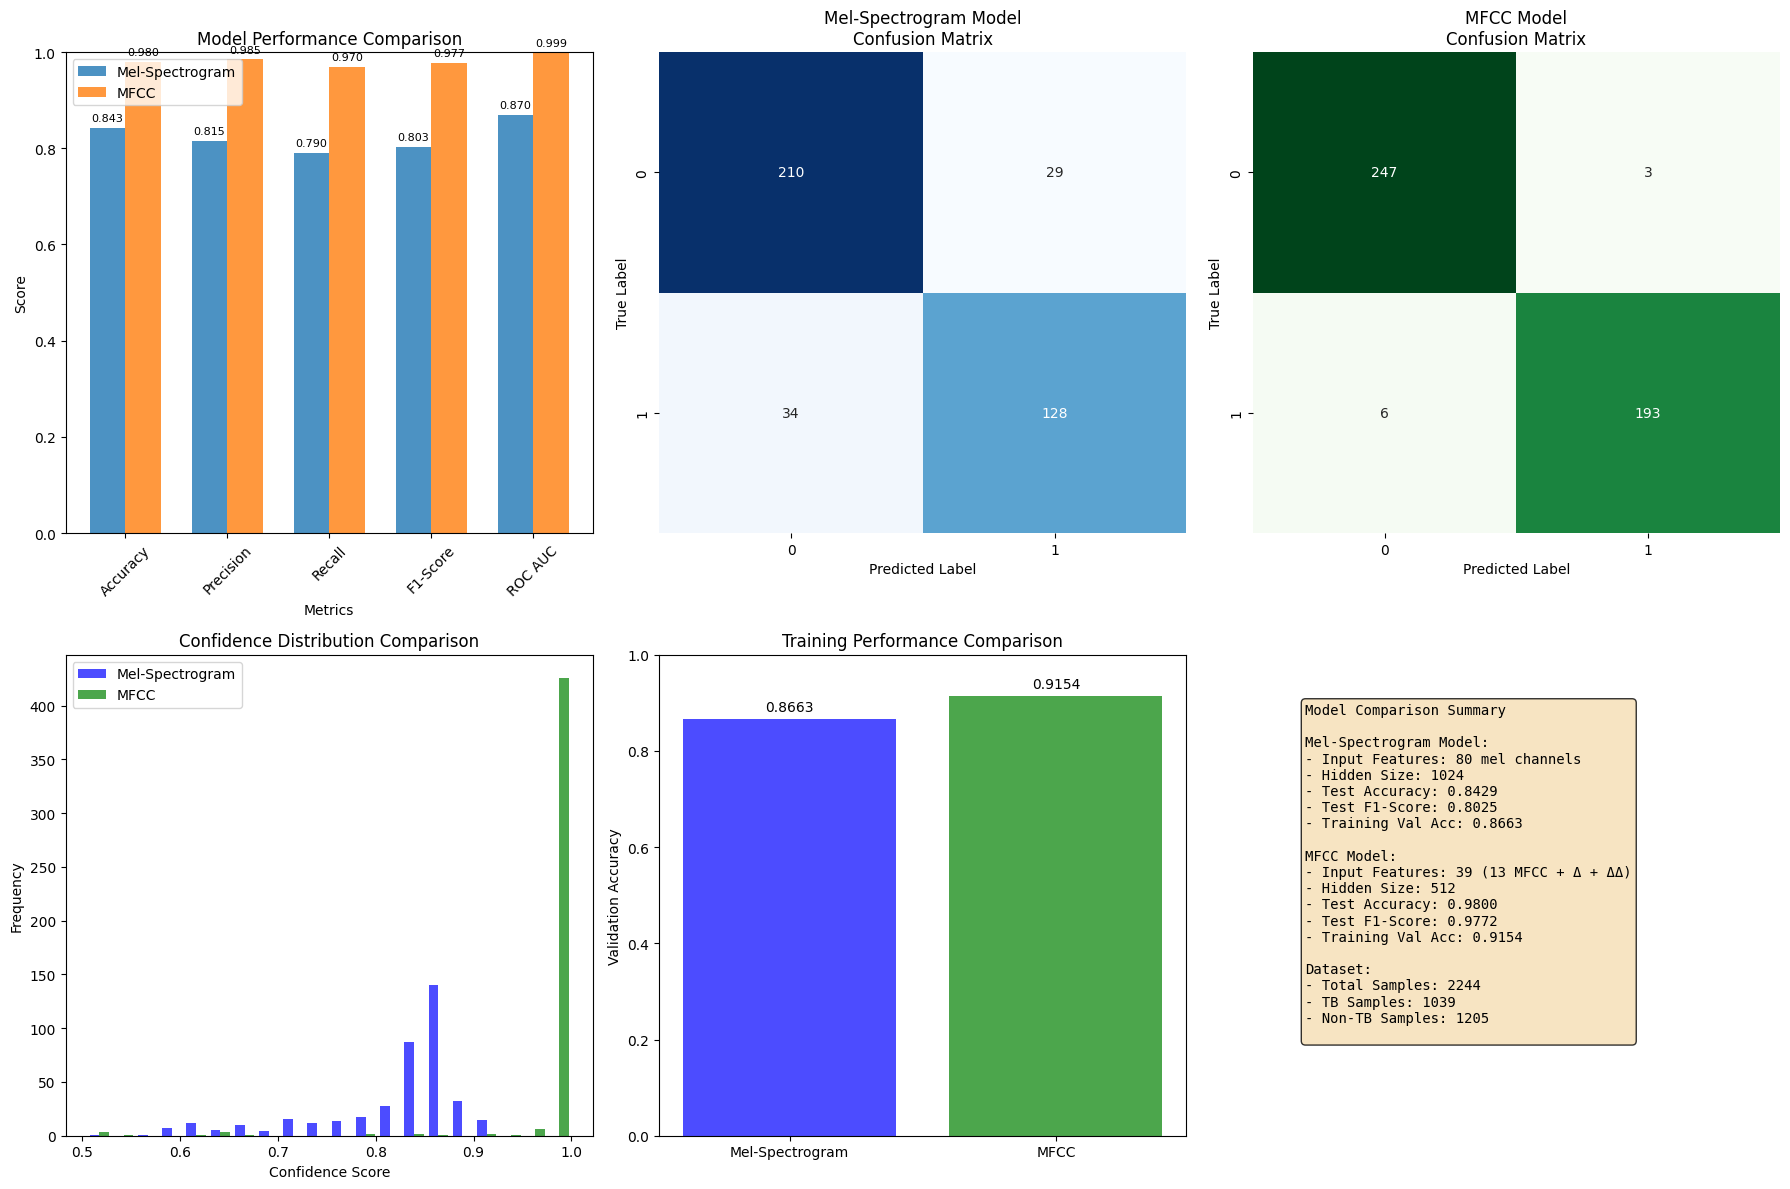

In [85]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
comparison_data = {
    'Mel-Spectrogram Model': [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc],
    'MFCC Model': [mfcc_test_accuracy, mfcc_test_precision, mfcc_test_recall, mfcc_test_f1, mfcc_test_roc_auc]
}
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, comparison_data['Mel-Spectrogram Model'], width, label='Mel-Spectrogram', alpha=0.8)
plt.bar(x + width/2, comparison_data['MFCC Model'], width, label='MFCC', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.ylim(0, 1)

for i, (mel_val, mfcc_val) in enumerate(zip(comparison_data['Mel-Spectrogram Model'], comparison_data['MFCC Model'])):
    plt.text(i - width/2, mel_val + 0.01, f'{mel_val:.3f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width/2, mfcc_val + 0.01, f'{mfcc_val:.3f}', ha='center', va='bottom', fontsize=8)

plt.subplot(2, 3, 2)
mel_cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(mel_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Mel-Spectrogram Model\nConfusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(2, 3, 3)
mfcc_cm = confusion_matrix(mfcc_y_true, mfcc_y_pred)
sns.heatmap(mfcc_cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('MFCC Model\nConfusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(2, 3, 4)
plt.hist([y_conf_test, mfcc_y_conf], bins=20, alpha=0.7, 
         label=['Mel-Spectrogram', 'MFCC'], color=['blue', 'green'])
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Distribution Comparison')
plt.legend()

plt.subplot(2, 3, 5)
training_comparison = {
    'Mel-Spectrogram': training_results['best_val_acc'],
    'MFCC': mfcc_training_results['best_val_acc']
}
plt.bar(training_comparison.keys(), training_comparison.values(), 
        color=['blue', 'green'], alpha=0.7)
plt.ylabel('Validation Accuracy')
plt.title('Training Performance Comparison')
plt.ylim(0, 1)

for model, acc in training_comparison.items():
    plt.text(model, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom')

plt.subplot(2, 3, 6)
plt.axis('off')
summary_text = f"""Model Comparison Summary

Mel-Spectrogram Model:
- Input Features: 80 mel channels
- Hidden Size: 1024
- Test Accuracy: {test_accuracy:.4f}
- Test F1-Score: {test_f1:.4f}
- Training Val Acc: {training_results['best_val_acc']:.4f}

MFCC Model:
- Input Features: 39 (13 MFCC + Δ + ΔΔ)
- Hidden Size: 512
- Test Accuracy: {mfcc_test_accuracy:.4f}
- Test F1-Score: {mfcc_test_f1:.4f}
- Training Val Acc: {mfcc_training_results['best_val_acc']:.4f}

Dataset:
- Total Samples: {total_samples}
- TB Samples: {tb_count}
- Non-TB Samples: {ntb_count}
"""

plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, 
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('model_comparison_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

MFCC Model Confusion Matrix:
True Negatives:  247
False Positives: 3
False Negatives: 6
True Positives:  193


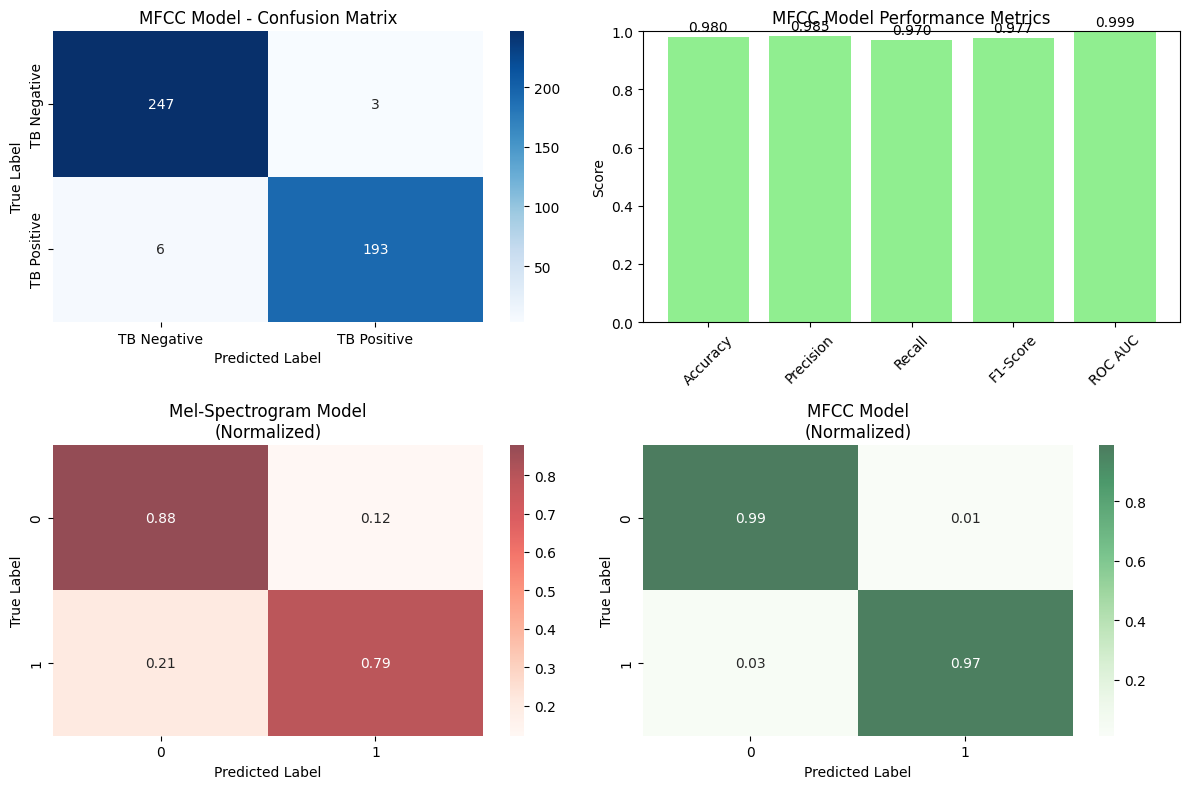


MFCC Model - Detailed Classification Report:
              precision    recall  f1-score   support

 TB Negative       0.98      0.99      0.98       250
 TB Positive       0.98      0.97      0.98       199

    accuracy                           0.98       449
   macro avg       0.98      0.98      0.98       449
weighted avg       0.98      0.98      0.98       449


MFCC Model - Additional Metrics:
Sensitivity (Recall): 0.9698
Specificity:          0.9880
PPV (Precision):      0.9847
NPV:                  0.9763

Model Comparison:
        Metric  Mel-Spectrogram    MFCC
0     Accuracy           0.8429  0.9800
1    Precision           0.8153  0.9847
2       Recall           0.7901  0.9698
3     F1-Score           0.8025  0.9772
4      ROC AUC           0.8696  0.9992
5  Sensitivity           0.7901  0.9698
6  Specificity           0.8787  0.9880


In [ ]:
# Create confusion matrix for MFCC model
plt.figure(figsize=(12, 8))

# Subplot 1: MFCC Model Confusion Matrix
plt.subplot(2, 2, 1)
mfcc_cm = confusion_matrix(mfcc_y_true, mfcc_y_pred)
sns.heatmap(mfcc_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['TB Negative', 'TB Positive'], 
            yticklabels=['TB Negative', 'TB Positive'])
plt.title('MFCC Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Calculate metrics for MFCC model
tn_mfcc, fp_mfcc, fn_mfcc, tp_mfcc = mfcc_cm.ravel()
print(f"MFCC Model Confusion Matrix:")
print(f"True Negatives:  {tn_mfcc}")
print(f"False Positives: {fp_mfcc}")
print(f"False Negatives: {fn_mfcc}")
print(f"True Positives:  {tp_mfcc}")

# Subplot 2: MFCC Model Metrics
plt.subplot(2, 2, 2)
mfcc_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
mfcc_values = [mfcc_test_accuracy, mfcc_test_precision, mfcc_test_recall, mfcc_test_f1, mfcc_test_roc_auc]
bars = plt.bar(mfcc_metrics, mfcc_values, color='lightgreen')
plt.title('MFCC Model Performance Metrics')
plt.ylabel('Score')
plt.ylim([0, 1])
for bar, value in zip(bars, mfcc_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')
plt.xticks(rotation=45)

# Subplot 3: Comparison of both models' confusion matrices
plt.subplot(2, 2, 3)
# Normalize confusion matrices for better comparison
mel_cm_norm = confusion_matrix(y_true_test, y_pred_test, normalize='true')
sns.heatmap(mel_cm_norm, annot=True, fmt='.2f', cmap='Reds', alpha=0.7)
plt.title('Mel-Spectrogram Model\n(Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(2, 2, 4)
mfcc_cm_norm = confusion_matrix(mfcc_y_true, mfcc_y_pred, normalize='true')
sns.heatmap(mfcc_cm_norm, annot=True, fmt='.2f', cmap='Greens', alpha=0.7)
plt.title('MFCC Model\n(Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Print detailed classification report for MFCC model
print(f"\nMFCC Classification Report:")
print(classification_report(mfcc_y_true, mfcc_y_pred, 
                          target_names=['TB Negative', 'TB Positive']))

# Calculate additional metrics for MFCC model
mfcc_sensitivity = tp_mfcc / (tp_mfcc + fn_mfcc)
mfcc_specificity = tn_mfcc / (tn_mfcc + fp_mfcc)
mfcc_ppv = tp_mfcc / (tp_mfcc + fp_mfcc)
mfcc_npv = tn_mfcc / (tn_mfcc + fn_mfcc)

print(f"\nMFCC Model - Additional Metrics:")
print(f"Sensitivity (Recall): {mfcc_sensitivity:.4f}")
print(f"Specificity:          {mfcc_specificity:.4f}")
print(f"PPV (Precision):      {mfcc_ppv:.4f}")
print(f"NPV:                  {mfcc_npv:.4f}")

# Side-by-side comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Sensitivity', 'Specificity'],
    'Mel-Spectrogram': [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, 
                       test_recall, tn/(tn+fp)],
    'MFCC': [mfcc_test_accuracy, mfcc_test_precision, mfcc_test_recall, mfcc_test_f1, 
            mfcc_test_roc_auc, mfcc_sensitivity, mfcc_specificity]
})

print(f"\nModel Comparison:")
print(comparison_df.round(4))